In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
import os
import healpy as hp
from rubin_sim.scheduler.utils import EuclidOverlapFootprint

In [2]:
baseline_file = get_baseline()
run_name = os.path.basename(baseline_file).replace('.db', '')

In [3]:
nside = 128

bundle_list = []

# have depth every month
bins = np.arange(0,3653, 30)

metric = maf.AccumulateM5Metric(bins=bins)
slicer = maf.HealpixSlicer(nside=nside)
sql = "filter='r' and note not like '%DD%'"

bundle_list.append(maf.MetricBundle(metric, slicer, sql))


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [4]:
mbg = maf.MetricBundleGroup(bundle_list, baseline_file, out_dir='temp')
mbg.run_all()

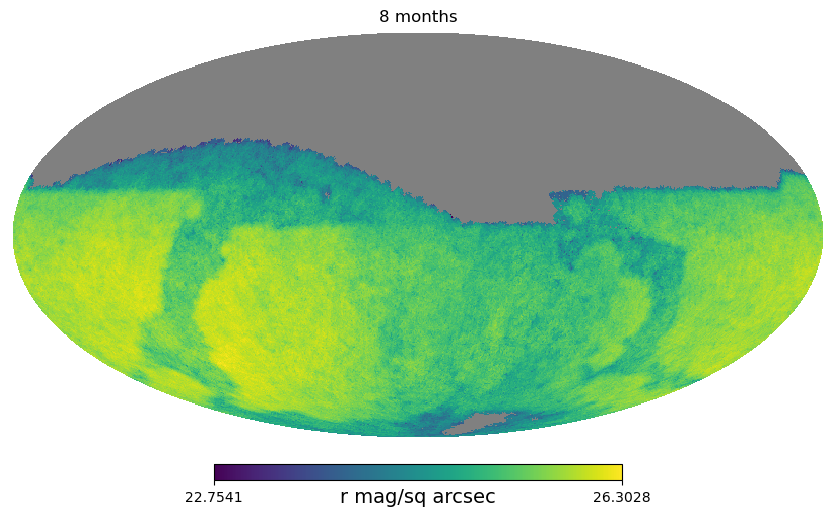

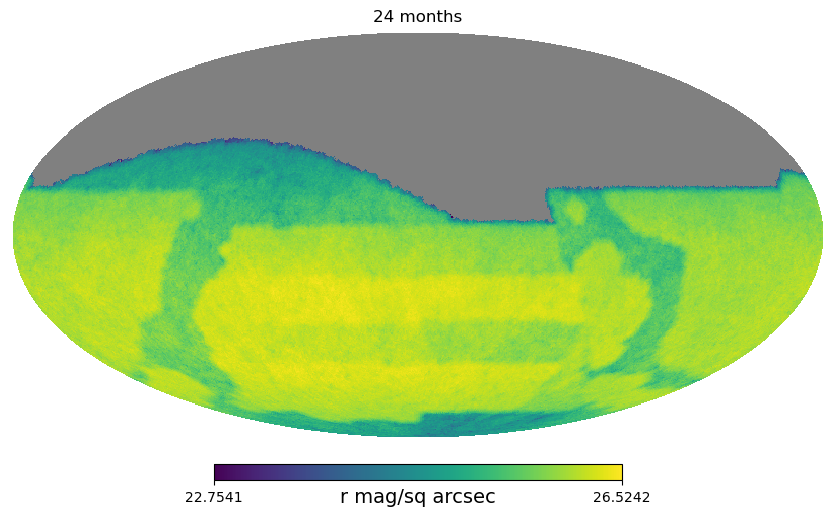

In [5]:
# Now we can look at the coadded depth as function of time
# After 8 and 24 months

hp.mollview(bundle_list[0].metric_values[:,8], unit="r mag/sq arcsec", title='8 months')


hp.mollview(bundle_list[0].metric_values[:,24], unit="r mag/sq arcsec", title='24 months')



In [6]:
# Let's load up the goal footprint so we can specify the WFD area:
sag = EuclidOverlapFootprint(nside=nside)
sky_maps, labels = sag.return_maps()
np.unique(labels)

array(['', 'LMC_SMC', 'bulgy', 'dusty_plane', 'euclid_overlap', 'lowdust',
       'nes', 'scp', 'virgo'], dtype='<U20')

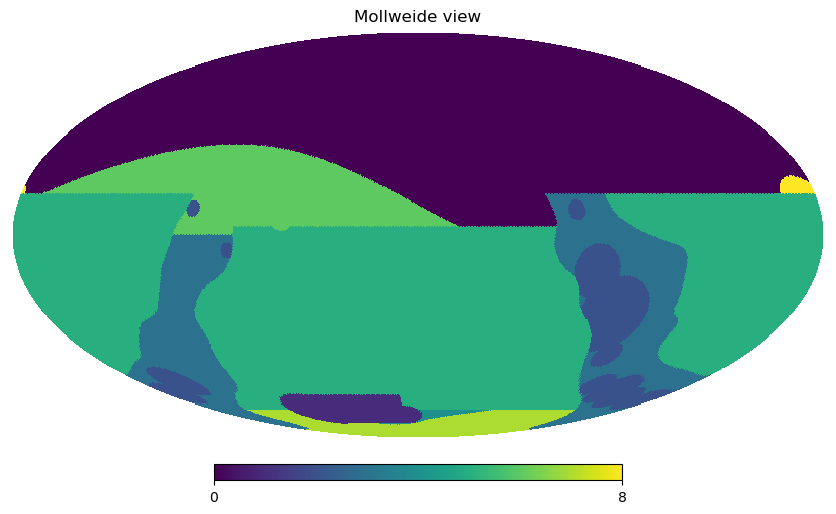

In [7]:
label_map = sky_maps['r'] * 0
for i,label in enumerate(np.unique(labels)):
    gp = np.where(labels == label)[0]
    label_map[gp] = i
hp.mollview(label_map)

In [8]:
wfd_pix = np.where( (labels=="lowdust") | (labels=="virgo") | (labels=="LMC_SMC") )[0]

In [9]:
wfd_depths = bundle_list[0].metric_values[wfd_pix,:]

/Users/yoachim/anaconda3/envs/rubin/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/yoachim/anaconda3/envs/rubin/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


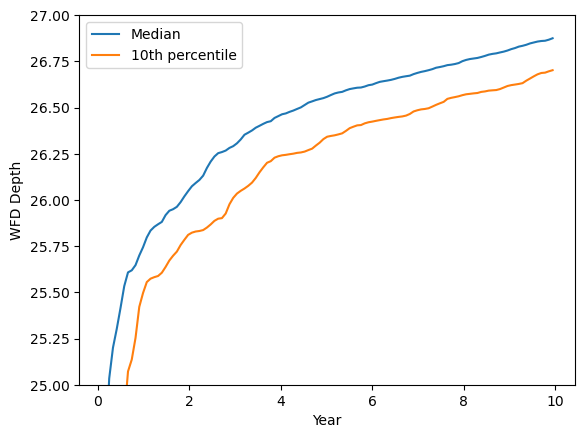

In [10]:

fix, ax = plt.subplots()

ax.plot(bins[1:]/365, np.median(wfd_depths, axis=0), label='Median')
ax.set_xlabel('Year')
ax.set_ylabel('WFD Depth')

ax.plot(bins[1:]/365, np.percentile(wfd_depths, 10, axis=0), label='10th percentile')

ax.set_ylim([25,27])
leg = plt.legend()

(0.0, 0.5)

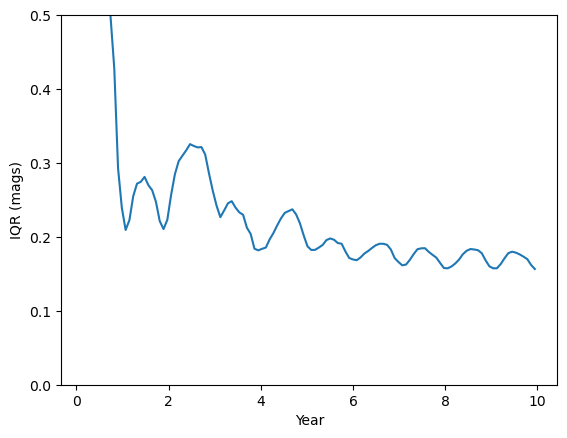

In [11]:
fix, ax = plt.subplots()
sq = np.percentile(wfd_depths, 25, axis=0)
tq = np.percentile(wfd_depths, 75, axis=0)

ax.plot(bins[1:]/365, tq-sq)
ax.set_ylabel('IQR (mags)')
ax.set_xlabel('Year')

ax.set_ylim([0.,0.5])

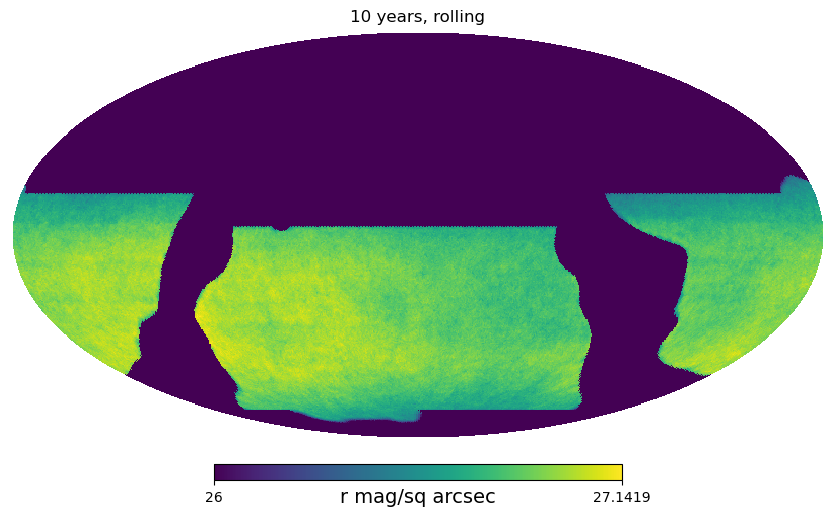

In [12]:
ack = np.zeros(bundle_list[0].metric_values[:,0].size)
ack[wfd_pix] = bundle_list[0].metric_values[wfd_pix,-1]
hp.mollview(ack, min=26, title='10 years, rolling', unit='r mag/sq arcsec')